# 모델링

In [1]:
# 주피터 노트북 전체화면 설정
from IPython.core.display import display, HTML
display(HTML("<style>.container {width:100% !important;}</style>"))

# 필요한 라이브러리 불러오기
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from pulp import *

## 1. 기본 모델
- 모델은 전압이 주어졌을 때 필요한 투입용량을 예측  
- 즉, 한전 프로젝트에 사용된 피처 중 '전압'만을 이용하여 투입용량을 예측  
- 투입용량은 곧 현재 작동되어야 하는 일반 리액터 및 가변형 리액터의 정보를 의미함  
- ex. 모델이 예측한 투입용량이 400 = 일반 리액터 2개가 투입되어야 함  
- [0,1,0]과 같은 discrete한 아웃풋으로 분류하는 것이 아닌 투입용량을 예측하는 이유? : 가변형 리액터는 현재 도입되지 않았으므로 이와 같이 모델을 설계하면 회사측은 성능 평가가 불가능함  
(모델이 예측한 탭 위치가 실제로 그러한지 예측 불가)
- 투입용량을 예측하도록 모델을 설계하면 가변형 리액터 혹은 일반 리액터인지 상관없이 성능평가가 가능함

In [2]:
# 데이터 불러오기 
data = pd.read_csv('전압데이터+투입용량_최종.csv')

# 데이터 추출
X = data['전압'].values.reshape(-1,1)
y = data['투입용량'].values

X.shape, y.shape

((298080, 1), (298080,))

In [4]:
# 데이터 분할
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

X_train.shape, X_test.shape, y_train.shape, y_train.shape

((238464, 1), (59616, 1), (238464,), (238464,))

In [5]:
# 모델 훈련, 예측, 성능측정
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print(mse)

35038.26585264746


In [6]:
# 한전 프로젝트에서 사용한 평가지표 (%)
acc = (y_test.sum() - y_pred.sum()) / y_test.sum() * 100
print(np.abs(acc),'%')

0.2877993464888637 %


- 모델의 성능은 고려할 필요가 없음  
 -> 현재 가상 데이터를 사용하므로  
 -> 모델의 성능 평가는 추후 회사에서 실제 데이터를 활용하여 진행  
- 하지만, 성능을 측정할 수 없다 = 어떤 모델을 사용해야하는지 알 수 없다.  
 -> 따라서, 회사 측에 관련된 정보를 '보고서 형식'으로 제공하는 것을 프로젝트 목표에 추가  
 -> 각 모델의 장단점에 따라 추천하는 모델 정보 제공  
 -> 모델의 성능 평가 방안 제공 (평가지표 등)  
 -> 모델 튜닝을 위한 방안 제공 (성능을 높이기 위해 하이퍼파라미터 조정 방법을 제안)  
 -> 추후에 회사측에서 보고서를 참고하여 모델 선정 및 평가, 튜닝을 원활히 진행할 수 있도록

## 2. 최적화
- 현재 모델은 투입용량을 예측  
- 하지만, 투입용량만으로는 자동화 시스템을 구성하는 데 부족함  
- 투입해야할 투입용량이 있을 때, 어떤 일반 리액터가 투입되어야 하고 가변형 리액터의 탭 파라미터는 어디에 있어야 하는지를 최종적인 결과로 도출할 수 있어야 함  
- 또한, 각 전력설비 투입 시 추가적인 비용을 고려해야 함  
- 즉, 만약 180만큼의 투입용량이 필요하다면 일반 리액터 하나를 투입할지(투입용량 200), 아니면 가변형 리액터를 투입하고 탭 파라미터를 16으로 설정할지(투입용량 = 183)를 결정할 수 있는 기준이 필요함  
- 기준 : 각 전력설비의 사용 횟수  
- '전력설비는 다빈도로 동작시 고장을 야기할 수 있음'  
- 따라서, 예측한 만큼의 투입용량을 투입하되, 각 전력설비의 사용빈도를 고려하여 적절히 배분한다.  
 -> 최적화 문제

### 공식
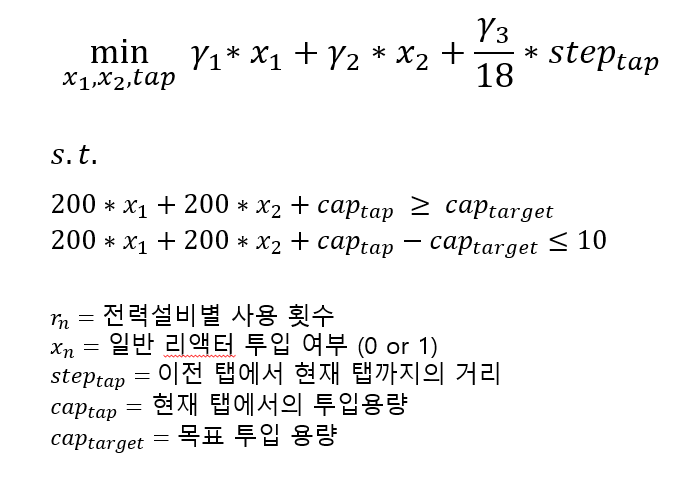

In [28]:
def optimize(cap_pred, params, used_counts) :
    
    table = np.zeros((19 * 4, 5))
    
    # 가변형 리액터 탭별 투입용량
    tap_cap = [0, 97, 101, 105, 109, 114, 119, 124, 129, 135, 140, 147, 153, 160, 167, 175, 183, 192, 200]
    
    # 현재 전력설비 상태 저장
    x1_now, x2_now, tap_now = params[0], params[1], params[2]
    
    # Cost 및 투입용량 계산 후 저장
    cnt = 0
    for i in range(2) :
        for j in range(2) :
            for k in range(0, 19) :
                # 투입용량
                cap = 200 * i + 200 * j + tap_cap[k]
                
                # Cost
                cost = used_counts[0] * np.abs(i - x1_now) + used_counts[1] * np.abs(j - x2_now) + (used_counts[2] / 18) * np.abs(k - tap_now)
                
                # 계산 결과 저장
                table[cnt] = [i,j,k,cap,cost]
                
                cnt += 1
    
    # 제약식 1
    cons1_ind = np.where(table[:,3] > cap_pred)
    table = table[cons1_ind]
    
    # 제약식 2
    cons2_ind = np.where(table[:,3] - cap_pred <= 10)
    table = table[cons2_ind]
    
    # 최종 결과
    optimized_ind = np.argmin(table[:,4])
    
    # 결과 저장
    x1_target, x2_target, tap_target = table[optimized_ind,0], table[optimized_ind,1], table[optimized_ind,2]
    
    return x1_target, x2_target, tap_target

## 적용 결과

In [29]:
# 예시1
cap_now = 297 # 현재 투입 용량
cap_pred = 507 # 예측한 필요 투입 용량
params = [1,0,1] # 현재 일반 리액터1 투입 상태, 일반 리액터2 투입 상태, 가변형 리액터 탭 위치
used_counts = [151, 120, 51] # 현재 각 전력설비별 사용 빈도

# 결과 : 일반 리액터 1 투입 유지, 일반 리액터 2 투입, 가변형 리액터 tap 위치 4로 변경
optimize(cap_pred, params, used_counts)

(1.0, 1.0, 4.0)

In [30]:
# 예시2
cap_now = 567 # 현재 투입 용량
cap_pred = 300 # 예측한 필요 투입 용량
params = [1,1,14] # 현재 일반 리액터1 투입 상태, 일반 리액터2 투입 상태, 가변형 리액터 탭 위치
used_counts = [151, 151, 51] # 현재 각 전력설비별 사용 빈도

# 결과 : 일반 리액터 1 개방, 일반 리액터 2 유지, 가변형 리액터 tap 위치 4로 변경
optimize(cap_pred, params, used_counts)

(0.0, 1.0, 4.0)